In [1]:
import sys
import os
import cv2
import numpy as np

from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.backend.tensorflow_backend import set_session

input_shape = (16, 48, 3)
target_size=(16, 48)

# Количество эпох
epochs = 50
# Размер мини-выборки
batch_size = 32
# Количество изображений для обучения
nb_train_samples = 600
# Количество изображений для проверки
nb_validation_samples = 100
# Количество изображений для тестирования
nb_test_samples = 100


Using TensorFlow backend.


In [2]:
from matplotlib import pyplot as plt
from keras.callbacks import Callback
from IPython.display import clear_output

class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

In [3]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255.0,rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, channel_shift_range=0.1,
	horizontal_flip=True, fill_mode = "reflect")

train_generator = datagen.flow_from_directory(
        'train\\',
        target_size=target_size,
        batch_size=batch_size,
        class_mode= 'binary')

test_generator = datagen.flow_from_directory('test\\',
                                                               target_size=target_size,
                                                               batch_size=batch_size,
                                                               class_mode= 'binary')

#score_generator = datagen.flow_from_directory('D:\\Anaconda\\projects\\fire\\score\\',
#                                                               target_size=target_size,
#                                                               batch_size=batch_size,
#                                                               class_mode='binary')

Found 189 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


In [4]:
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam

num_classes = 6

model = Sequential()
model.add(Conv2D(20, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(40, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(60, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='Nadam',
              metrics=['accuracy'])

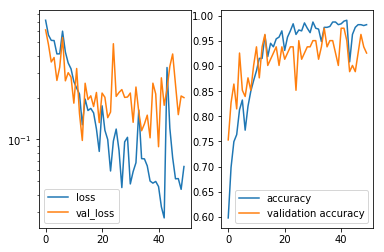

18/18 [==============================] - 9s 492ms/step - loss: 0.0638 - acc: 0.9825 - val_loss: 0.1998 - val_acc: 0.9259


In [5]:
model.fit_generator( 
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    shuffle=True,
    validation_data=test_generator,
    validation_steps=nb_test_samples // batch_size,
    callbacks=[plot])

In [6]:
score = model.evaluate_generator(score_generator, steps=50)
print("loss: " + str(score[0]) + "\naccuracy: "+str(score[1]))

loss: 0.499318838696
accuracy: 0.848387096005


In [ ]:
predictions = model.predict_generator(score_generator, steps=1)

In [24]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
